# EDC Project
## Task 1
Plot confusion matrix and find error rate


Error rate of k-NN classifier using 5 neighbors: 0.6060606060606061


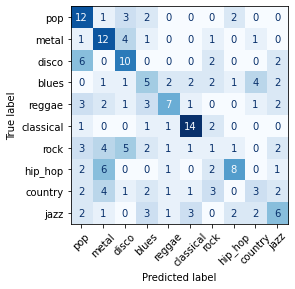

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from no_pipeline import Dataset
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm import SVC

filename = 'Classification music/GenreClassData_30s.txt'
feat = ['spectral_centroid_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'tempo']
genre_data = Dataset(filename , 5, feat, None)

genre_data.scale()
error_rate = genre_data.classify(method = 'knn',conf_matrix = True)
print("Error rate of k-NN classifier using 5 neighbors:", error_rate)
plt.show()



## Task 2
Plot histogram for each feature for each class
(Also for extra spice, plot the scatter plot)

In [ ]:
gen = ['pop', 'metal', 'disco','classical']
feat = ['rmse_mean', 'spectral_bandwidth_mean', 'spectral_contrast_var','tempo']
genre_data = Dataset(filename, 5, feat, gen)
genre_data.scale()
all_params = genre_data.hist(2,2, legend=True)
plt.show()

Tempo showed most overlap. Removing it, then the others

In [ ]:
gen = ['pop', 'metal', 'disco','classical']
feat = ['spectral_centroid_mean', 'spectral_rolloff_mean', 'mfcc_1_mean']
genre_data = Dataset(filename, 5, feat, gen)
genre_data.scale()

er = genre_data.classify('knn',True)
genre_data.three_feature_plot()
print("Error rate when removing Tempo:" , er)
plt.show()

In [ ]:
gen = ['pop', 'metal', 'disco','classical']
feat = ['spectral_centroid_mean', 'spectral_rolloff_mean', 'tempo']
genre_data = Dataset(filename, 5, feat, gen)
genre_data.scale()

er  = genre_data.classify('knn',True)
genre_data.three_feature_plot()
print("Error rate when removing MFCC:" , er)
plt.show()

In [ ]:
gen = ['pop', 'metal', 'disco','classical']
feat = [ 'spectral_rolloff_mean', 'mfcc_1_mean', 'tempo']
genre_data = Dataset(filename, 5, feat, gen)
genre_data.scale()

er = genre_data.classify('knn',True)
print("Error rate when removing SCM:" , er)
genre_data.three_feature_plot()
plt.show()

In [ ]:
gen = ['pop', 'metal', 'disco','classical']
feat = ['spectral_centroid_mean', 'mfcc_1_mean', 'tempo']
genre_data = Dataset(filename, 5, feat, gen)
genre_data.scale()

er = genre_data.classify('knn',True)
print("Error rate when removing SRM:" , er)
genre_data.three_feature_plot()
plt.show()

## Task 3
Design a k-nn classifier for all ten genres using three of the previous features and one more.
Choosing by analyzing all histograms visually, choosing four, analyzing variance and correlation visually (Just for hypothesis), cross-correlating and choosing the best one.

### All histograms
Not very visible in Jupyter unfortunately

In [ ]:
#genre_data = Dataset(filename, 5, feat, None)
#genre_data.hist(8,8,False)
#plt.show()


In [ ]:
## LOOK AT CORRELATION
filename = 'Classification music/GenreClassData_30s.txt'
feat = ['spectral_centroid_mean', 'mfcc_1_mean', 'spectral_rolloff_mean', 'spectral_contrast_var']
test_features = ['rmse_mean', 'spectral_bandwidth_mean', 'spectral_contrast_var','chroma_stft_12_std']
for f in test_features:
    feat[3] = f
    genre_data = Dataset(filename, 5, feat, None)
    genre_data.scale()
    genre_data.train_data.index = list(range(len(genre_data.train_data.index))) # to avoid a pairplot error
    sns.pairplot(genre_data.train_data)
plt.show()

In [ ]:
## CROSS-CORRELATE, and pick feature
feat = ['spectral_centroid_mean', 'mfcc_1_mean', 'spectral_rolloff_mean', 'spectral_contrast_var']
test_features = ['rmse_mean', 'spectral_bandwidth_mean', 'spectral_contrast_var','chroma_stft_12_std']
kfold = KFold(shuffle=True, random_state=1)
best_feature = ''
best_score = 0
genre_data = Dataset(filename, 5, feat, None)
genre_data.scale()
X = genre_data.train_data.values
Y = genre_data.train_labels.values
for f in test_features:
    feat[3] = f
    knn = KNeighborsClassifier()
    score = np.mean(cross_val_score(knn,X,Y,cv = kfold))
    if score > best_score:
        best_score = score
        best_feature = f

print("Best feature: ", best_feature)
print("score", best_score)
feat[3] = best_feature
genre_data = Dataset(filename, 5, feat, None)
genre_data.scale()
er = genre_data.classify(method='knn',conf_matrix=True)
print("Error rate using",best_feature,"as fourth feature: ", er)

In [ ]:
# FIND OPTIMAL NUMBER OF PCS
genre_data = Dataset(filename, 5, None, None)
genre_data.scale('z-score')
control = 1- genre_data.classify('SVM')
pca_scores = []


kfold = KFold(shuffle=True, random_state=1)

for i in range(1,64):
    genre_data = Dataset('Classification music/GenreClassData_30s.txt', 5, None, None)
    genre_data.scale(normalization_method='z-score')
    genre_data.do_pca(i)
    X = genre_data.train_data.values
    Y = genre_data.train_labels.values
    svc = SVC()
    score = np.mean(cross_val_score(svc,X,Y,cv=kfold))
    pca_scores.append(score)

PCs = np.argmax(pca_scores) + 1
best_mean_score = np.amax(pca_scores)
print("Optimal no of PCs: ", PCs)
print("Best mean score: ", best_mean_score)
print("Control, using all features: ", control)

genre_data = Dataset('Classification music/GenreClassData_30s.txt', 5, None, None)
genre_data.scale('z-score')
genre_data.do_pca(PCs)
control_pca = 1- genre_data.classify('SVM')
print("Score using optimum number of PCs: ", control_pca)

## Task 4


In [ ]:
## FIND OPTIMAL KERNEL AND PARAMETERS
kernels = ['rbf','linear']
Cs = [0.001,0.1,1,10,100,1000,1000]
gammas = [0.001,0.001,0.01,0.1,1,10,100,1000, 'scale','auto']

best_kernel = ''
best_C = 1
best_gamma = 1
genre_data = Dataset(filename, 5, None, None)
genre_data.scale('z-score')
genre_data.do_pca(45)
for kern in kernels:
    for c in Cs:
        for gam in gammas:
            kfold = KFold(shuffle=True, random_state=1)
            if kern == 'rbf':
                svc = SVC(kernel = kern, C = c, gamma = gam)
            else:
                svc = SVC(kernel = kern,C=c)
            X = genre_data.train_data.values
            Y = genre_data.train_labels.values
            score = np.mean(cross_val_score(svc,X,Y,cv=kfold))
            if score > best_score:
                best_kernel, best_C, best_gamma =  kern, c, gam
                best_score = score

print("Best kernel function: ", best_kernel)
print("Best C: ", best_C)
if best_kernel == 'rbf':
    print("Best gamma: ", best_gamma)
print("Best mean score: ", best_score)

genre_data = Dataset('Classification music/GenreClassData_30s.txt', 5, None, None)
genre_data.do_pca(45)
genre_data.scale('z-score')
er = genre_data.classify('SVM', conf_matrix=True, kernel=best_kernel, C=best_C, gamma=best_gamma)
print("Error rate using best parameters: ", er)
plt.show()



## Exxxtra


In [6]:
# FIND OPTIMAL NUMBER OF PCS
genre_data = Dataset(filename, 5, None, None)
genre_data.scale('z-score')
control = 1- genre_data.classify('knn')
pca_scores = []


kfold = KFold(shuffle=True, random_state=1)

for i in range(1,64):
    genre_data = Dataset('Classification music/GenreClassData_30s.txt', 5, None, None)
    genre_data.scale(normalization_method='z-score')
    genre_data.do_pca(i)
    X = genre_data.train_data.values
    Y = genre_data.train_labels.values
    knn = KNeighborsClassifier()
    score = np.mean(cross_val_score(knn,X,Y,cv=kfold))
    pca_scores.append(score)

PCs = np.argmax(pca_scores) + 1
best_mean_score = np.amax(pca_scores)
print("Optimal no of PCs: ", PCs)
print("Best mean score: ", best_mean_score)
print("Control, using all features: ", control)

genre_data = Dataset('Classification music/GenreClassData_30s.txt', 5, None, None)
genre_data.scale('z-score')
genre_data.do_pca(PCs)
control_pca = 1- genre_data.classify('knn')
print("Score using optimum number of PCs: ", control_pca)

Optimal no of PCs:  41
Best mean score:  0.6250139320117825
Control, using all features:  0.6414141414141414
Score using optimum number of PCs:  0.6414141414141414
